# Keyphrase Extraction using Word2Vec with Spectral Clustering

## 1. Importing Libraries

In [5]:
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import nltk,re, pprint
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.chunk.regexp import *
from nltk.corpus import stopwords
from nltk.chunk.regexp import tag_pattern2re_pattern 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import state_union

## 2. Text Processing 
        This Step includes removing the stop words , tokenize the text to convert into sentences and converting each word into lower case.

In [6]:
# Set Parameters
n_clusters = 100    # No. Of Clusters
stop_words = set(stopwords.words('english'))
Actual_Summary = "output.txt"

def text_processing(file):
    f = open(file, 'r', encoding='utf-8')
    text = f.read()
    
    #Tokenization : Convert to sentences and then to words
    sentences = nltk.sent_tokenize(text)
    
    data = []
    for sent in sentences:
        words = nltk.word_tokenize(sent)
        words = [w.lower() for w in words if len(w)>2 and w not in stop_words]
        data.append(words)
        
    return data

text = text_processing("input.txt")
print("Text Processing : done")


count_frequency = {}
for line in text:
    for w in line:
        count_frequency[w] = 0
        
for line in text:
    for w in line:
        count_frequency[w] = count_frequency[w] + 1
            
candidate_term = len(count_frequency.keys())

print(candidate_term)

Text Processing : done
152


## 3. Word2Vec Model 

In [7]:
from gensim.models import Word2Vec

model = Word2Vec(text, size=300, window = 10, min_count=1)
words = list(model.wv.vocab)

print("Word2Vec Model : done")

Word2Vec Model : done


In [8]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,300), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
display_closestwords_tsnescatterplot(model, words[0])

/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


<Figure size 640x480 with 1 Axes>

## 4. Spectral Clustering Applied

/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  # Remove the CWD from sys.path while we load stuff.
/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


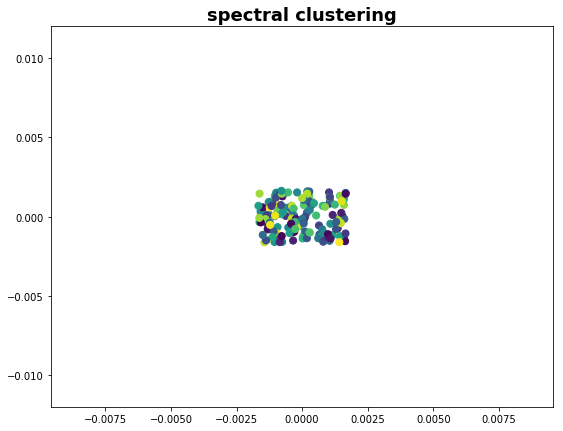

In [41]:
# Implement Spectral Clustering

from sklearn.cluster import SpectralClustering
dot_size=50
cmap = 'viridis'

n_clusters = int(candidate_term*4/5)
model_spectral = SpectralClustering(n_clusters, affinity='nearest_neighbors', assign_labels='kmeans')

labels = model_spectral.fit_predict(model.wv.syn0)

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('spectral clustering', fontsize=18, fontweight='demi')
plt.scatter(model.wv.syn0[:, 0], model.wv.syn0[:, 1], c=labels, s=dot_size, cmap=cmap)


## 5. Applied K-Means and Regular Expression Parser

In [42]:
from scipy.spatial import distance
from sklearn.cluster import KMeans
import numpy as np

y_hc = []       
y_hc = labels.copy()              # Output Of Spectral Clustering : A list 
summary = []

print("***************************************************************************************************")

# Extracting The Keyword by choosing the mean of cluster
def Extracted_Keywords(clus, clus_name):
    
    kmeans = KMeans(n_clusters=1, random_state=0).fit(clus)
    labels = kmeans.labels_
    mean = kmeans.cluster_centers_.reshape(300,1)
    min_to_centre = []
    
    for i in clus:
        Y = distance.cdist(i.reshape(300,1), mean, 'euclidean')
        sum_Y = np.sum(Y)
        min_to_centre.append(sum_Y)

    min_value = min(min_to_centre)
    ind_value = np.argmin(min_to_centre)
    
#     print(ind_value)
#     print(clus_name[ind_value])  
    summary.append(clus_name[ind_value])
    
    
    
for j in range(0,n_clusters):
    clus = []
    clus_name = []
    count = 0
    for i in range(len(y_hc)):
        if(y_hc[i] == j):
            count += 1
            clus.append(model[words[i]])
            clus_name.append(words[i])
    
    Extracted_Keywords(clus, clus_name)
    
    
# print(nltk.pos_tag(summary))

# Grammar Regular Expression
# grammar = "chunk:{(<JJ>)*(<NN | NNS | NNP>)+} " 
# chunkParser= RegexpParser(grammar)
# tagged = nltk.pos_tag(summary)
# result = chunkParser.parse(tagged)

# for subtree in result.subtrees():
#     print(subtree)
# result.draw()

print("done")


***************************************************************************************************


/home/varun/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


done


In [ ]:
import collections
summary_frequency = {}

for word in summary:
    summary_frequency[word] = count_frequency[word]
    
od = sorted(summary_frequency.items(), key=lambda x: x[1])
od = od[::-1]

result = []

for i in range(0,20):
    result.append(od[i][0])

    
    
# Regular Expression Parser
grammar = "chunk:{(<JJ>)*(<NN | NNS | NNP>)+} " 
chunkParser= RegexpParser(grammar)
tagged = nltk.pos_tag(result)
result = chunkParser.parse(tagged)
for subtree in result.subtrees():
    print(subtree)
result.draw()


(S
  the/DT
  (chunk bittorrent/NN)
  files/VBZ
  host/RBS
  (chunk lokitorrent/JJ december/NN server/NN)
  called/VBN
  (chunk networks/NNS)
  (chunk legal/JJ servers/NNS movie/NN links/NNS)
  agreed/VBD
  (chunk others/NNS)
  said/VBD
  illegally/RB
  across/IN
  (chunk file-sharers/NNS network/NN))
(chunk bittorrent/NN)
(chunk lokitorrent/JJ december/NN server/NN)
(chunk networks/NNS)
(chunk legal/JJ servers/NNS movie/NN links/NNS)
(chunk others/NNS)
(chunk file-sharers/NNS network/NN)


In [44]:
right_lis=[]
def getNodes(parent):
    print(parent.label())
    for node in parent:
      
        if type(node) is nltk.Tree:
            if node.label() == 'chunk':
                print("hii")
                #print(node.leaves())
                right_lis.append(node.leaves())
                #print("Sentence:", " ".join(node.leaves()))  
                
            
            else:
                print(node.label())
        else:
            pass
        print(node)  
        
getNodes(result)
print("done")


S
('the', 'DT')
hii
(chunk bittorrent/NN)
('files', 'VBZ')
('host', 'RBS')
hii
(chunk lokitorrent/JJ december/NN server/NN)
('called', 'VBN')
hii
(chunk networks/NNS)
hii
(chunk legal/JJ servers/NNS movie/NN links/NNS)
('agreed', 'VBD')
hii
(chunk others/NNS)
('said', 'VBD')
('illegally', 'RB')
('across', 'IN')
hii
(chunk file-sharers/NNS network/NN)
done


In [45]:

keyphrase=[]
str1=''
for i in range(len(right_lis)):
    for j in range(len(right_lis[i])):
        for k in range(len(right_lis[i][j])-1):
            if right_lis[i][j][k+1] != 'JJ':
             
                str1=str1+right_lis[i][j][k]
                keyphrase.append(str1)
                str1=''
            else:
            
                str1=str1+right_lis[i][j][k] + ' '
    str1=' '
print(right_lis)
print(keyphrase)

[[('bittorrent', 'NN')], [('lokitorrent', 'JJ'), ('december', 'NN'), ('server', 'NN')], [('networks', 'NNS')], [('legal', 'JJ'), ('servers', 'NNS'), ('movie', 'NN'), ('links', 'NNS')], [('others', 'NNS')], [('file-sharers', 'NNS'), ('network', 'NN')]]
['bittorrent', ' lokitorrent december', 'server', ' networks', ' legal servers', 'movie', 'links', ' others', ' file-sharers', 'network']


## 6. Results : Precision, Recall, F-Measure

In [46]:
from rouge import Rouge 

def Calculate_Score():
    str2 = ""
    for i in summary:
        str2 = str2 + i
        str2 = str2 + " "
    
    print("Predicted Summary : \n")
    print(str2)

    print("\n\n")
    
    
    f = open(Actual_Summary, 'r', encoding='utf-8')
    text = f.read()
    
    print("Actual Summary : \n")
    print(text)

    rouge = Rouge()
    scores = rouge.get_scores(text, str2)
    print("\n\n")
    
    print("F-Measure : ", scores[0]['rouge-1']['f'])
    print("Precision : ", scores[0]['rouge-1']['p'])
    print("Recall    : ", scores[0]['rouge-1']['r'])
    
Calculate_Score()

Predicted Summary : 

content allowed bittorrent continents uses click copying close clamping networks copyrighted files every targeting would industry films adding court called association succeeded file 100 edonkey trackers filing infringe dvds 30,000 message phoenix but server sites peer-to-peer system like systems motion action lawsuits claimed network records material getting since file-sharers stark ability n't given lawyers october another stunt dallas popular across illegally torrent struck the also aggressively access swap link round worried said number others shared copyright share could agreed came links using high-profile videos similar latest soon followed single appeared take hit december campaign nets america sharing already costs online hits suits copied movie they programmes servers well notices lokitorrent host four picture began illegal people hitting legal film strategy closed 



Actual Summary : 

It has filed 100 lawsuits against operators of BitTorrent server si